# Importing Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date

In [2]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

In [4]:
# For resampling
from imblearn.over_sampling import SMOTE

# Loading Files

In [5]:
main_df = pd.read_csv('Prepared Frames/rated_v3.csv')

In [6]:
main_df.shape

(8652, 45)

## We drop the column that is a transformation of our target

In [7]:
print(main_df.columns)

Index(['Ticker', 'Company Name', 'IndustryId', 'Fiscal Year', 'Fiscal Period',
       'Report Date', 'Shares (Diluted)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses

In [8]:
df = main_df.drop(['Investment_Grade','Rating_numbered'],axis = 1)

## We drop columns that are just noise and not relevant to our model

In [9]:
# drop_columns = ['Ticker', 'SimFinId', 'Company Name','tokens',
#        'current_search', 'Fiscal Year', 'Fiscal Period', 'Report Date',
#        'Shares (Diluted)','Sector', 'IndustryId','reduced_matches']

In [10]:
drop_columns = ['Ticker', 'Company Name',
       'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)','Sector', 'IndustryId','reduced_matches']

In [11]:
df = df.drop(drop_columns, axis = 1)

# Introducing calculated columns
From a financial standpoint, the different columns do not really mean a lot by themself.
I will bring some of them into relation with each other by calculating some basic financial metrics and see if this helps
our model.

In [12]:
# These are simplified calculations, the goal is not to have super accurate financial metrics, but to have some
# meaningful relation between the values, since for example having 1 million dollar is nice, but not if you have 200 million in debt.
def calc_fields(df):
    df['leverage'] = df['Total Liabilities']/df['Total Assets']
#     df['taxrate'] = (df['Pretax Income (Loss)'] - df['Net Income'])/df['Pretax Income (Loss)'] Tax rate made it worse
#     df['cost_of_revenue_to_revenue'] = df['Cost of Revenue']/df['Revenue']
    # I add 1 to the ínterest expense, since some values are 0
    df['interest_ratio'] = df['Interest Expense, Net']/df['Total Liabilities']*-100
    df['cost_of_capital_to_operating_income'] = df['Interest Expense, Net']/(df['Income (Loss) from Continuing Operations']+1)
    df['income_to_interest'] = (df['Interest Expense, Net']/df['Pretax Income (Loss)'])*-1
#     df['shortterm_assets_to_liabilities'] = df['Total Current Liabilities']/df['Total Liabilities']
    return df

In [13]:
def revert_fields(df):
    df = df.drop(['leverage','taxrate','cost_of_revenue_to_revenue','cost_of_capital_to_operating_income','short_liabilities_to_liabilities'])

In [14]:
df = calc_fields(df)

There was a noticeable improvement in scores even with just one added field, I will consecutively try our more.

# First Model

## X-y split

In [15]:
X = df.drop('Rating',axis = 1)
y = df['Rating']

## Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Num-Cat-Split

In [17]:
# We have almost exclusively numerical columns, only the Industry column is categorical

# for column in X.columns:
#     print(column)
#     print(X[column].dtype)

In [18]:
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

## Onehot encoding

In [19]:
# Fit encoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_cat)

# Getting the column names for the later selection
column_name = encoder.get_feature_names_out(X_train_cat.columns)

# Encode train and test
train_encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns = column_name, index=X_train_cat.index)
test_encoded = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns = column_name, index=X_test_cat.index)

## Scaling

In [20]:
# Fitting scaler, after trying Standard- and MinMaxScaler I saw the MinMaxScaler delivers better results.
transformer = MinMaxScaler().fit(X_train_num)

# Scaling train and test data
train_num_scaled = pd.DataFrame(transformer.transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)
test_num_scaled = pd.DataFrame(transformer.transform(X_test_num), columns = X_test_num.columns, index = X_test_num.index)

In [21]:
X_train_num.shape

(6921, 34)

## Concatenating

In [22]:
X_train = pd.concat([train_encoded, train_num_scaled], axis = 1)
X_test = pd.concat([test_encoded,test_num_scaled], axis = 1)

In [23]:
# Saving so we can revert back later
X_train_unedited = X_train
X_test_unedited = X_test
y_train_unedited = y_train
y_test_unedited = y_test

In [24]:
X_test.shape

(1731, 100)

## Testing models

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier

In [26]:
# A function that I made in the Random Forest Lab to try out some models
def model_test(X_train,X_test,y_train,y_test):
    # Creating a list of different models
    modellist = [LogisticRegression(solver='sag'),
                 DecisionTreeClassifier(max_depth=7),
                 neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance'),
                 RandomForestClassifier(max_depth=7,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             n_jobs = -1),
                 ExtraTreesClassifier(n_estimators=100),
                 LinearSVC(),
                 BaggingClassifier()
                ]
    modelnames = ['Logistic Regression','DecisionTree','KNN','RandomForest','ExtraTrees','LinearSVC','BaggingClassifier']
    #Evaluating each model
    for i in range(len(modellist)):
        model = modellist[i]
        # Fitting
        model.fit(X_train, y_train)
        # Predicting
        predictions = model.predict(X_test)
        # Calculating confusion matrix
        cm = confusion_matrix(y_test, predictions)
        print(cm)
        # Printing different evaluation metrics
        print(modelnames[i] + " score: ", model.score(X_test, y_test))
        print(modelnames[i] + " precision: ",precision_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " recall: ",recall_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " f1: ",f1_score(y_test,predictions, average = 'weighted'))

In [27]:
model_test(X_train,X_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 27   1   0   1  29  15   0   0   0]
 [  2  11   1   1   9   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 243 265   0   0   2   0]
 [  1   0   0 120 689   9   0   0   0]
 [  8   0   0  22 135  65   0   0   0]
 [  0   0   0   3   0   0   0   1   0]
 [  0   0   0  22  23   0   0   5   0]
 [  0   0   0   8   3   3   0   2   0]]
Logistic Regression score:  0.6036972848064702
Logistic Regression precision:  0.6065959663576785
Logistic Regression recall:  0.6036972848064702
Logistic Regression f1:  0.5746594369638791
[[ 63   0   0   1   6   2   0   0   1]
 [  5  19   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  1   0   0 377 118   3   0   8   3]
 [  5   0   0 120 684  10   0   0   0]
 [ 14   1   0  11 123  81   0   0   0]
 [  0   0   0   3   0   0   0   1   0]
 [  0   0   0  26   8   0   0  16   0]
 [  0   0   0   5   3   2   0   2   4]]
DecisionTree score:  0.7215482380127094
DecisionTree precision:  0.7259210456161449
DecisionTree recall:  

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 70   0   0   1   0   2   0   0   0]
 [  1  21   2   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 463  33   3   1  10   0]
 [  0   0   0  28 783   6   0   2   0]
 [  7   0   0   5   6 212   0   0   0]
 [  0   0   0   2   0   0   1   1   0]
 [  0   0   0  11   6   0   0  33   0]
 [  0   0   0   3   1   2   1   0   9]]
KNN score:  0.9225880993645291
KNN precision:  0.9224988687527468
KNN recall:  0.9225880993645291
KNN f1:  0.9217257819129187
[[ 37   0   0   7  23   6   0   0   0]
 [ 16   2   0   0   4   2   0   0   0]
 [  3   2   0   0   0   0   0   0   0]
 [  0   0   0 332 177   1   0   0   0]
 [  2   0   0  85 721  11   0   0   0]
 [ 14   0   0  12 151  53   0   0   0]
 [  0   0   0   4   0   0   0   0   0]
 [  0   0   0  38  12   0   0   0   0]
 [  0   0   0  10   4   2   0   0   0]]
RandomForest score:  0.6614673599075679
RandomForest precision:  0.6353347402293335
RandomForest recall:  0.6614673599075679
RandomForest f1:  0.6227249031464019


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 73   0   0   0   0   0   0   0   0]
 [  1  23   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 487  22   0   0   1   0]
 [  0   0   0  15 804   0   0   0   0]
 [  3   0   0   0   5 222   0   0   0]
 [  0   0   0   1   0   0   2   1   0]
 [  0   0   0   5   0   0   0  45   0]
 [  0   0   0   2   2   0   1   1  10]]
ExtraTrees score:  0.9653379549393414
ExtraTrees precision:  0.965474785576223
ExtraTrees recall:  0.9653379549393414
ExtraTrees f1:  0.9648585287080275
[[ 32   1   0   2  24  14   0   0   0]
 [  3  11   2   0   7   0   0   1   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 259 250   0   0   1   0]
 [  1   0   0 123 685  10   0   0   0]
 [  7   0   0  18 133  69   0   3   0]
 [  0   0   0   3   0   0   0   1   0]
 [  0   0   0  26  23   0   0   1   0]
 [  0   0   0   9   2   3   0   2   0]]
LinearSVC score:  0.6135181975736569
LinearSVC precision:  0.6066396744409621
LinearSVC recall:  0.6135181975736569
LinearSVC f1:  0.5856286911

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 72   0   0   0   0   1   0   0   0]
 [  1  23   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 473  27   0   0  10   0]
 [  0   0   0  41 774   4   0   0   0]
 [  4   0   0   0  17 209   0   0   0]
 [  0   0   0   1   0   0   1   1   1]
 [  0   0   0  12   2   0   0  36   0]
 [  0   0   0   4   4   0   1   0   7]]
BaggingClassifier score:  0.9243212016175621
BaggingClassifier precision:  0.9241946644676209
BaggingClassifier recall:  0.9243212016175621
BaggingClassifier f1:  0.9231563996916589


Conclusion:
We see similar scores across the models, the issue is, that we are missing some values within the datasets.

## Resampling
I will try to resample the data using SMOTE and see if we can improve the results.

In [28]:
# # Resampling does not work, since we do not have an example of every class in our dataframe to begin with.
# sm = SMOTE(random_state=100, k_neighbors=1)
# X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,y_train)

#### We retry to run our models

In [29]:
# model_test(X_train_SMOTE,X_test,y_train_SMOTE,y_test)

Resampling was not possible after selecting train and test by companies, since we do not have an entry for every class anymore.

## Feature selection

#### Taking out columns I introduced myself

In [30]:
# First i try if I can eliminate the columns I created myself earlier. Since the information is already in other columns.
Xperiment_train = X_train.drop(['interest_ratio','income_to_interest'],axis = 1)
Xperiment_test = X_test.drop(['interest_ratio','income_to_interest'],axis = 1)

In [31]:
model_test(Xperiment_train,Xperiment_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 27   1   0   1  29  15   0   0   0]
 [  2  11   1   1   9   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 231 277   0   0   2   0]
 [  1   0   0 123 686   9   0   0   0]
 [  8   0   0  24 133  65   0   0   0]
 [  0   0   0   3   0   0   0   1   0]
 [  0   0   0  20  25   0   0   5   0]
 [  0   0   0   8   3   3   0   2   0]]
Logistic Regression score:  0.5950317735413057
Logistic Regression precision:  0.5983151054778204
Logistic Regression recall:  0.5950317735413057
Logistic Regression f1:  0.5655513256208021
[[ 61   0   0   6   5   1   0   0   0]
 [  5  18   1   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 339 167   3   0   0   1]
 [  3   0   0  81 724  11   0   0   0]
 [ 23   1   0   3 118  85   0   0   0]
 [  0   0   0   3   0   0   0   0   1]
 [  0   0   0  37   6   0   0   7   0]
 [  0   0   0   4   5   2   0   0   5]]
DecisionTree score:  0.7186597342576545
DecisionTree precision:  0.7350736855681618
DecisionTree recall:  

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 70   0   0   1   0   2   0   0   0]
 [  1  21   2   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 451  43   4   1  10   1]
 [  1   0   0  35 774   7   0   2   0]
 [  7   0   0   5   7 211   0   0   0]
 [  0   0   0   2   0   0   1   1   0]
 [  0   0   0  13   4   0   0  31   2]
 [  0   0   0   4   1   2   1   0   8]]
KNN score:  0.9081455805892548
KNN precision:  0.9069713013379342
KNN recall:  0.9081455805892548
KNN f1:  0.9070589961014228
[[ 37   0   0   7  21   8   0   0   0]
 [ 18   0   0   0   3   3   0   0   0]
 [  5   0   0   0   0   0   0   0   0]
 [  0   0   0 320 189   1   0   0   0]
 [  2   0   0  89 718  10   0   0   0]
 [  8   0   0   9 156  57   0   0   0]
 [  0   0   0   4   0   0   0   0   0]
 [  0   0   0  40  10   0   0   0   0]
 [  0   0   0  10   6   0   0   0   0]]
RandomForest score:  0.6539572501444252
RandomForest precision:  0.6229777815723506
RandomForest recall:  0.6539572501444252
RandomForest f1:  0.6150013136529562


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 72   0   0   0   0   1   0   0   0]
 [  1  22   1   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 488  19   0   0   3   0]
 [  0   0   0  13 806   0   0   0   0]
 [  3   0   0   0   4 223   0   0   0]
 [  0   0   0   1   0   0   2   1   0]
 [  0   0   0   6   0   0   0  44   0]
 [  0   0   0   2   2   0   1   0  11]]
ExtraTrees score:  0.9664933564413634
ExtraTrees precision:  0.9665850875329568
ExtraTrees recall:  0.9664933564413634
ExtraTrees f1:  0.9661226694070122
[[ 34   1   0   2  23  13   0   0   0]
 [  3  11   2   0   7   0   0   1   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 254 255   0   0   1   0]
 [  1   0   0 123 685  10   0   0   0]
 [  7   0   0  22 128  70   0   3   0]
 [  0   0   0   3   0   0   0   1   0]
 [  0   0   0  25  24   0   0   1   0]
 [  0   0   0   9   3   3   0   1   0]]
LinearSVC score:  0.6123627960716349
LinearSVC precision:  0.6060766852211737
LinearSVC recall:  0.6123627960716349
LinearSVC f1:  0.584555366

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 71   0   0   0   0   2   0   0   0]
 [  1  22   1   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 479  26   1   0   4   0]
 [  1   0   0  34 780   2   0   2   0]
 [  3   0   0   0  15 212   0   0   0]
 [  0   0   0   2   0   0   1   0   1]
 [  0   0   0  14   1   0   0  35   0]
 [  0   0   0   5   4   0   1   1   5]]
BaggingClassifier score:  0.9300982091276718
BaggingClassifier precision:  0.9294778951692931
BaggingClassifier recall:  0.9300982091276718
BaggingClassifier f1:  0.928109121813728


The results got slightly worse, we kep the columns.

## Feature selection with KBest

In [32]:
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.feature_selection import chi2

In [33]:
# First we do a quick transformation and see if we achieve anything this way
model = SelectKBest(chi2, k=20).fit(X_train, y_train)
XTr_temp = pd.DataFrame(model.transform(X_train), index = X_train.index)
Xte_temp = pd.DataFrame(model.transform(X_test), index = X_test.index)

In [34]:
model_test(XTr_temp,Xte_temp,y_train,y_test)

[[ 23   0   0   1  37  12   0   0   0]
 [  0  10   0   4  10   0   0   0   0]
 [  0   2   0   0   0   3   0   0   0]
 [  0   0   0 102 408   0   0   0   0]
 [  0   0   0  53 757   9   0   0   0]
 [  0   0   0  14 170  46   0   0   0]
 [  0   0   0   2   2   0   0   0   0]
 [  0   0   0  15  35   0   0   0   0]
 [  0   0   0   7   6   3   0   0   0]]
Logistic Regression score:  0.5418833044482958
Logistic Regression precision:  0.5405745632872745
Logistic Regression recall:  0.5418833044482958
Logistic Regression f1:  0.4723663516795496
[[ 42   0   0   6  12  13   0   0   0]
 [  2  10   0   0  11   1   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  6   0   0 313 177   8   0   6   0]
 [ 14   0   0 185 601  19   0   0   0]
 [ 18   0   0  21 112  78   0   1   0]
 [  0   0   0   2   1   0   0   0   1]
 [  0   0   0  28  11   0   0   9   2]
 [  0   0   0   6   1   1   0   2   6]]
DecisionTree score:  0.6146735990756788
DecisionTree precision:  0.616785881452863
DecisionTree recall:  0

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 53   1   0   7   5   7   0   0   0]
 [  1  19   1   0   1   2   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  2   0   0 352 125  13   0  18   0]
 [  5   0   0 137 646  23   0   7   1]
 [ 11   2   0  19  48 147   0   3   0]
 [  0   0   0   2   1   0   0   0   1]
 [  0   0   0  12   3   0   0  35   0]
 [  0   0   0   3   1   0   1   1  10]]
KNN score:  0.731946851530907
KNN precision:  0.7338434702933608
KNN recall:  0.731946851530907
KNN f1:  0.7315789781789707
[[  0   0   0   6  55  12   0   0   0]
 [  0   0   0   0  24   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0]
 [  0   0   0 273 237   0   0   0   0]
 [  0   0   0 140 671   8   0   0   0]
 [  0   0   0  20 182  28   0   0   0]
 [  0   0   0   3   1   0   0   0   0]
 [  0   0   0  30  20   0   0   0   0]
 [  0   0   0   8   5   3   0   0   0]]
RandomForest score:  0.561525129982669
RandomForest precision:  0.5050805949184989
RandomForest recall:  0.561525129982669
RandomForest f1:  0.5034583713268491


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 56   0   0   1   5  11   0   0   0]
 [  1  19   1   0   1   2   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  2   0   0 365 127   7   0   9   0]
 [  3   0   0 121 668  20   0   6   1]
 [  8   1   0  18  51 150   0   2   0]
 [  0   0   0   2   1   0   0   0   1]
 [  0   0   0  15   3   0   0  32   0]
 [  0   0   0   4   0   0   0   0  12]]
ExtraTrees score:  0.755054881571346
ExtraTrees precision:  0.7546715584062417
ExtraTrees recall:  0.755054881571346
ExtraTrees f1:  0.7535896086215546


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 23   0   0   0  37  13   0   0   0]
 [  0   9   1   2  10   2   0   0   0]
 [  0   0   2   0   0   3   0   0   0]
 [  7   0   0  99 401   0   0   3   0]
 [  9   0   0  47 754   9   0   0   0]
 [  0   0   0  10 170  47   0   3   0]
 [  0   0   0   2   2   0   0   0   0]
 [  2   0   0  15  33   0   0   0   0]
 [  0   0   0   7   6   3   0   0   0]]
LinearSVC score:  0.5395725014442518
LinearSVC precision:  0.5332891928286997
LinearSVC recall:  0.5395725014442518
LinearSVC f1:  0.47067248259922867


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 59   0   0   1   5   8   0   0   0]
 [  1  19   1   0   1   2   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  6   0   0 365 120   8   0  10   1]
 [  5   0   0 128 654  24   0   6   2]
 [  6   0   0  21  55 146   0   2   0]
 [  0   0   0   2   1   0   0   0   1]
 [  0   0   0  12   5   0   0  31   2]
 [  0   0   0   3   1   1   0   0  11]]
BaggingClassifier score:  0.7452339688041595
BaggingClassifier precision:  0.7451188275407098
BaggingClassifier recall:  0.7452339688041595
BaggingClassifier f1:  0.7438967610389992


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I tried out different values for K, it deteriorates our scores , we see what happens when trying to eliminate multicollinearity.

## Eliminating multicollinearity

Since the most relevant columns were the encoded categoricals, and there was no multicollinearity, I temporarily take them out, so that I can see and handle the multicollinearity in the numerical columns.

In [35]:
X_train_temp = train_num_scaled
X_test_temp = test_num_scaled

In [36]:
# I will reuse a function from my Random Forest Lab

# The function creates aheatmap of the best X columns from a Kbest test and returns the columnnames so we can work with them
def corr_check(model, df_input, number_of_columns):
    # Making a dataframe of the scores and column names
    df = pd.DataFrame(data = model.scores_, columns = ['score'])
    df['Column'] = df_input.columns
    # Sort it
    df_sorted = df.sort_values(by = ['score'], ascending = False).reset_index()
    # Making a list of the first x columns
    collist = []
    for i in range(number_of_columns):
        collist.append(df_sorted['Column'][i])
    # creating a correlation matrix
    correlations_matrix = df_input[collist].corr()
    # create a heatmap of it
    plt.figure(figsize = (16,16))
    sns.heatmap(correlations_matrix, annot=True, fmt='.2f')
    plt.show()
    return collist

In [37]:
model = SelectKBest(chi2, k=32).fit(X_train_temp, y_train)

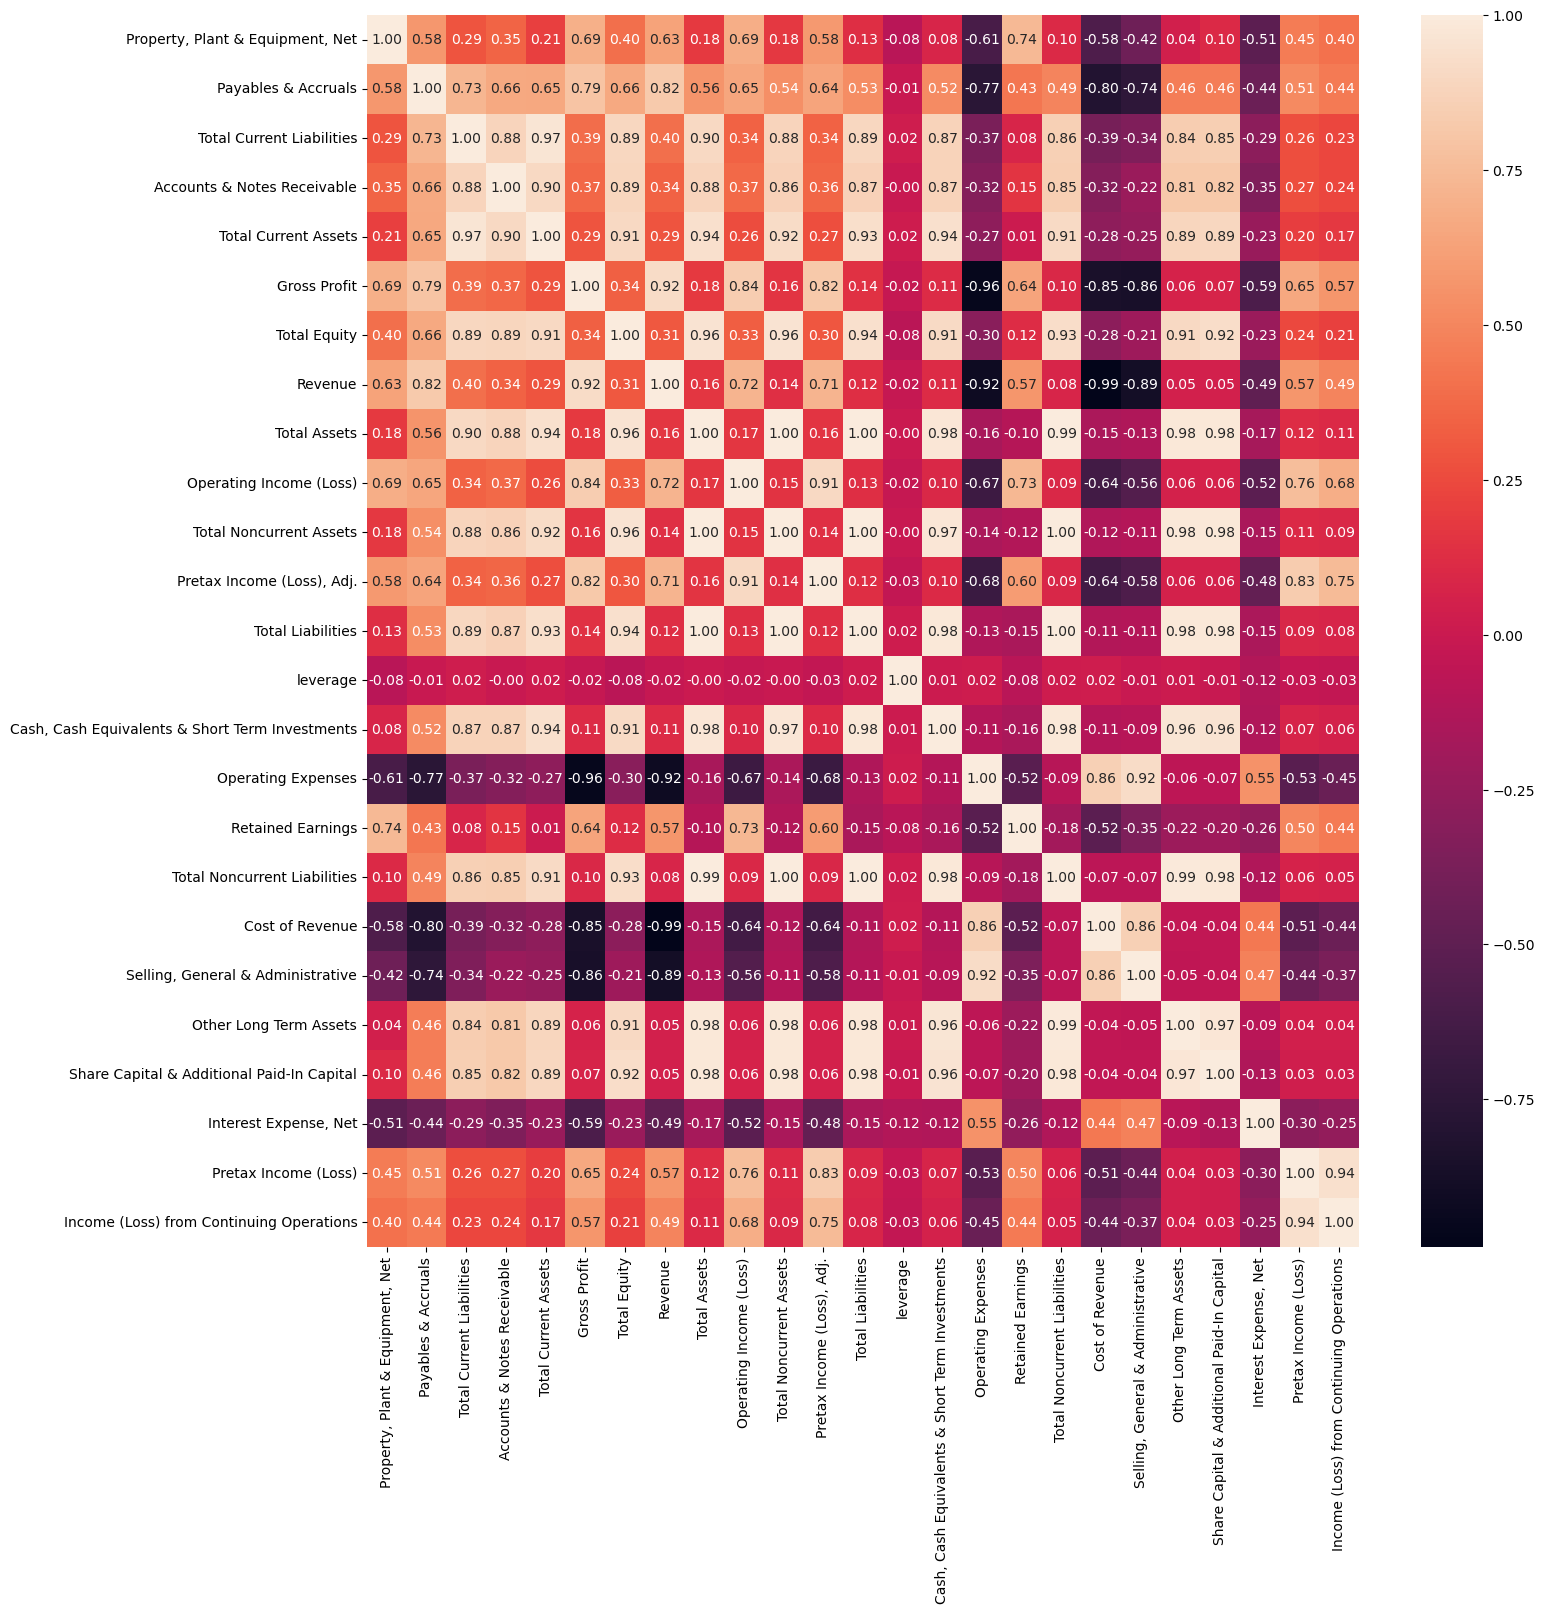

In [38]:
collist = corr_check(model,X_train_temp, 25)

In [39]:
print(collist)

['Property, Plant & Equipment, Net', 'Payables & Accruals', 'Total Current Liabilities', 'Accounts & Notes Receivable', 'Total Current Assets', 'Gross Profit', 'Total Equity', 'Revenue', 'Total Assets', 'Operating Income (Loss)', 'Total Noncurrent Assets', 'Pretax Income (Loss), Adj.', 'Total Liabilities', 'leverage', 'Cash, Cash Equivalents & Short Term Investments', 'Operating Expenses', 'Retained Earnings', 'Total Noncurrent Liabilities', 'Cost of Revenue', 'Selling, General & Administrative', 'Other Long Term Assets', 'Share Capital & Additional Paid-In Capital', 'Interest Expense, Net', 'Pretax Income (Loss)', 'Income (Loss) from Continuing Operations']


In [40]:
# We see a lot of multicollinearity here ,so we take out some columns
droplist = ['Revenue','Cost of Revenue','Accounts & Notes Receivable', 'Total Current Assets','Total Equity', 'Total Assets',
           'Total Noncurrent Assets','Operating Expenses', 'Total Liabilities','Pretax Income (Loss), Adj.', 'Cash, Cash Equivalents & Short Term Investments','Other Long Term Assets',
           'Share Capital & Additional Paid-In Capital','Pretax Income (Loss)', 'Income (Loss) from Continuing Operations', 'Net Income']

In [41]:
# We drop the columns
X_train_temp = X_train_temp.drop(droplist,axis = 1)
X_test_temp = X_test_temp.drop(droplist,axis = 1)

In [42]:
X_train_temp.shape

(6921, 18)

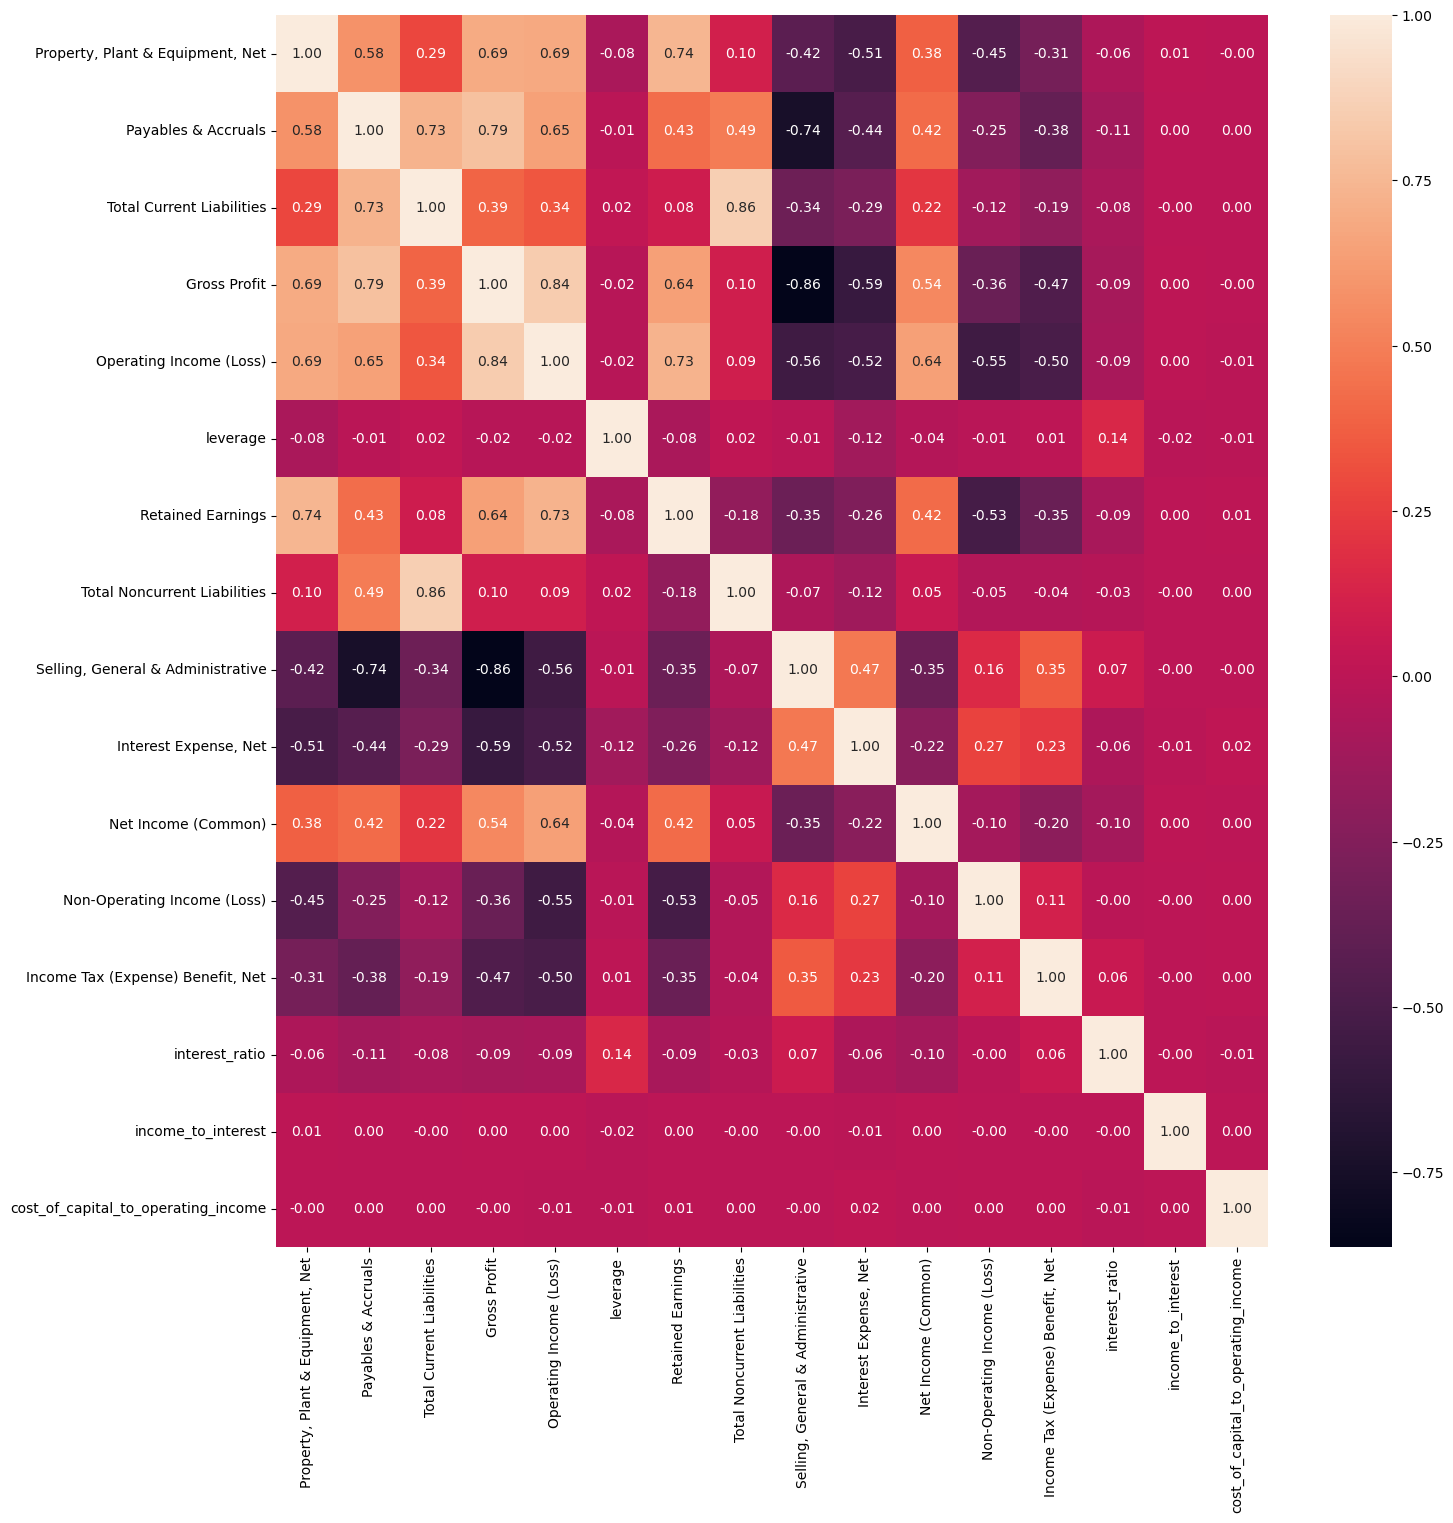

In [43]:
# We run it again
model = SelectKBest(chi2, k=16).fit(X_train_temp, y_train)
collist = corr_check(model,X_train_temp, 16)

In [44]:
# Looks like we got rid of most of the multicollinearity, we try out how the models perform with the new setup

In [45]:
# We put back our categrocial data
X_train_temp = pd.concat([X_train_temp, train_num_scaled], axis = 1)
X_test_temp = pd.concat([X_test_temp,test_num_scaled], axis = 1)

In [46]:
model_test(X_train_temp,X_test_temp,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 10   0   0   1  57   5   0   0   0]
 [  1   6   1   0  13   3   0   0   0]
 [  3   0   2   0   0   0   0   0   0]
 [  0   0   0 115 395   0   0   0   0]
 [  0   0   0  46 763  10   0   0   0]
 [  9   0   0   4 198  19   0   0   0]
 [  0   0   0   4   0   0   0   0   0]
 [  0   0   0  25  25   0   0   0   0]
 [  0   0   0   4  10   2   0   0   0]]
Logistic Regression score:  0.5285961871750433
Logistic Regression precision:  0.51621377801356
Logistic Regression recall:  0.5285961871750433
Logistic Regression f1:  0.4467929465858617
[[ 53   0   0   0  10  10   0   0   0]
 [  5  19   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  3   0   0 397  97   4   0   8   1]
 [  5   0   0 131 655  28   0   0   0]
 [ 12   1   0  13  76 127   0   1   0]
 [  0   0   0   3   0   0   0   1   0]
 [  0   0   0  26   8   0   0  16   0]
 [  0   0   0   6   5   0   0   2   3]]
DecisionTree score:  0.7365684575389948
DecisionTree precision:  0.7352367410678838
DecisionTree recall:  0.

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 67   0   0   0   1   5   0   0   0]
 [  1  21   2   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  1   0   0 420  69   5   0  11   4]
 [  7   0   0  70 723  15   0   3   1]
 [  5   0   0   4  28 192   0   0   1]
 [  0   0   0   2   1   0   1   0   0]
 [  0   0   0  21   8   0   0  21   0]
 [  1   0   0   7   1   3   0   0   4]]
KNN score:  0.8399768919699596
KNN precision:  0.8374830938782888
KNN recall:  0.8399768919699596
KNN f1:  0.8372196039507593
[[ 44   0   0   7  16   6   0   0   0]
 [ 16   3   0   0   0   5   0   0   0]
 [  2   3   0   0   0   0   0   0   0]
 [  0   0   0 364 145   1   0   0   0]
 [  3   0   0  91 711  14   0   0   0]
 [  7   0   0  11 141  71   0   0   0]
 [  0   0   0   4   0   0   0   0   0]
 [  0   0   0  42   8   0   0   0   0]
 [  0   0   0  10   5   1   0   0   0]]
RandomForest score:  0.6891969959560947
RandomForest precision:  0.6595740449126063
RandomForest recall:  0.6891969959560947
RandomForest f1:  0.6569898826777971


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 73   0   0   0   0   0   0   0   0]
 [  1  23   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 487  23   0   0   0   0]
 [  0   0   0  14 805   0   0   0   0]
 [  4   0   0   0  11 215   0   0   0]
 [  0   0   0   1   0   0   2   1   0]
 [  0   0   0   9   0   0   0  41   0]
 [  0   0   0   3   4   0   1   0   8]]
ExtraTrees score:  0.9584055459272097
ExtraTrees precision:  0.9590344717284972
ExtraTrees recall:  0.9584055459272097
ExtraTrees f1:  0.9574292547819413
[[ 17   0   0   1  53   2   0   0   0]
 [  5   6   2   0   9   0   0   2   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 143 367   0   0   0   0]
 [  0   0   0  46 769   4   0   0   0]
 [  7   1   0   2 195  25   0   0   0]
 [  0   0   0   4   0   0   0   0   0]
 [  0   0   0  32  18   0   0   0   0]
 [  0   0   0   4  10   2   0   0   0]]
LinearSVC score:  0.5574812247255921
LinearSVC precision:  0.5769778058220059
LinearSVC recall:  0.5574812247255921
LinearSVC f1:  0.485513938

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 72   0   0   0   0   1   0   0   0]
 [  2  22   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 461  40   1   0   7   1]
 [  0   0   0  53 762   4   0   0   0]
 [  2   0   0   2  17 209   0   0   0]
 [  0   0   0   0   0   0   1   3   0]
 [  0   0   0  16   1   0   0  33   0]
 [  0   0   0   6   3   1   0   0   6]]
BaggingClassifier score:  0.9075678798382438
BaggingClassifier precision:  0.9082001623461091
BaggingClassifier recall:  0.9075678798382438
BaggingClassifier f1:  0.9060231229056952


Conclusion:
Our scores got a little worse, but we need way less data for our predictions, we will try to stiock with that.

In [47]:
X_train = X_train_temp
X_test = X_test_temp

## Hyperparameter search
Since eliminating multicollinearity did not change our result in a meaningful way before, we will now try to better the results with hyperparameter tuning for our best performing model.

In [48]:
# Random search
from sklearn.model_selection import RandomizedSearchCV

In [49]:
#  ExtraTrees classifier stands out with the best score, we will try to build on that
model = ExtraTreesClassifier()

In [50]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [51]:
parameters =  { 'n_estimators' : [100,300,500],
               'criterion': ['gini','entropy'],
               'max_features':['auto',None],
                'warm_start':[True,False],
                'class_weight':[None,'balanced'],
                'n_jobs' : [-1]
                }
              

In [52]:
random_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter=25, cv = 5, n_jobs = 10, scoring = "recall")

In [53]:
# Commented out, beacause it takes too long to rerun all the time

# random_search.fit(X_train,y_train)

# random_search.best_params_

In [54]:
# We try the model with the parameters
model = ExtraTreesClassifier( warm_start = False,
 n_jobs = -1,
 n_estimators = 300,
 max_features = 'auto',
 criterion = 'gini',
 class_weight = 'balanced')

In [55]:
model.fit(X_train, y_train)
# Predicting
predictions = model.predict(X_test)
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_test, y_test))
print(" precision: ",precision_score(y_test,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_test,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_test,predictions, average = 'weighted'))

[[ 73   0   0   0   0   0   0   0   0]
 [  1  22   1   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 481  28   0   0   1   0]
 [  0   0   0  14 805   0   0   0   0]
 [  3   0   0   1  10 216   0   0   0]
 [  0   0   0   1   0   0   2   1   0]
 [  0   0   0  11   1   0   0  38   0]
 [  0   0   0   3   4   1   1   0   7]]
 score:  0.9526285384170999
 precision:  0.953212273246575
 recall:  0.9526285384170999
 f1:  0.9512472269422413


In [56]:
# We tried to score for precision we try with the parameters delivered for that
model = ExtraTreesClassifier( warm_start = True,
 n_jobs = -1,
 n_estimators = 100,
 max_features = None,
 criterion = 'gini',
 class_weight= 'balanced')

In [57]:
model.fit(X_train, y_train)
# Predicting
predictions = model.predict(X_test)
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_test, y_test))
print(" precision: ",precision_score(y_test,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_test,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_test,predictions, average = 'weighted'))

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:765: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


[[ 73   0   0   0   0   0   0   0   0]
 [  1  22   1   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 483  26   0   0   1   0]
 [  0   0   0  20 799   0   0   0   0]
 [  4   0   0   0   9 217   0   0   0]
 [  0   0   0   1   0   0   2   1   0]
 [  0   0   0   9   1   0   0  40   0]
 [  0   0   0   1   4   0   1   0  10]]
 score:  0.9537839399191219
 precision:  0.9543429549391477
 recall:  0.9537839399191219
 f1:  0.953173050380401


This is slightly better, we are keeping this as our final model.

## Fitting all data
Since we now have decided for a final model I will fit it again with all available data.

In [58]:
# Putting all data together
X_all = pd.concat([X_train,X_test],axis = 0)
y_all = pd.concat([y_train,y_test],axis = 0)

In [59]:
model = ExtraTreesClassifier( warm_start = False,
 n_jobs = -1,
 n_estimators = 100,
 max_features = None,
 criterion = 'gini',
 class_weight= 'balanced')

In [60]:
# Fitting the model
model.fit(X_all, y_all)

ExtraTreesClassifier(class_weight='balanced', max_features=None, n_jobs=-1)

In [61]:
# Just out of curiosiuty testing with training data

In [62]:
predictions = model.predict(X_all)
# Calculating confusion matrix
cm = confusion_matrix(y_all, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_all, y_all))
print(" precision: ",precision_score(y_all,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_all,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_all,predictions, average = 'weighted'))

[[ 401    0    0    0    0    0    0    0    0    0]
 [   0   94    0    0    0    0    0    0    0    0]
 [   0    0   33    0    0    0    0    0    0    0]
 [   0    0    0 2633    0    0    0    0    0    0]
 [   0    0    0    0 4096    0    0    0    0    0]
 [   0    0    0    0    0  997    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0   10    0    0]
 [   0    0    0    0    0    0    0    0  285    0]
 [   0    0    0    0    0    0    0    0    0  102]]
 score:  1.0
 precision:  1.0
 recall:  1.0
 f1:  1.0


Looks quite overfittet, lets see how it performs on unseen data:

# Testing on unrated companies

We still have a lot of the dataset where we could not systematically get data for the companies.
I will run the model to predict some of the ratings and check them manually.

In [110]:
# Loading unused data
df_unrated = pd.read_csv('Prepared Frames/main_data.csv')

In [111]:
# We have not cleaned all this because we initially did not need to.
# Since we only can check a small number of samples,we drop all NaNs
df_unrated = df_unrated.dropna(axis = 0)
df_unrated.shape

(31204, 39)

## Selecting only relevant tickers

In [112]:
# We take just the part of the df where we do not have the tickers in our training and test data:
rated_tickers = list(main_df['Ticker'].unique())

In [113]:
# We exclude the already rated tickers
df_unrated = df_unrated[~df_unrated['Ticker'].isin(rated_tickers)]
df_unrated.shape

(21484, 39)

In [114]:
# Since we won't be able to get the historic rating data, we will just take the data for the latest year available "2021"
# So that when we check the ratings, they are as recent as possible
df_unrated = df_unrated[df_unrated['Fiscal Year'] ==2021]
df_unrated.shape

(4217, 39)

## Creating/Dropping the same columns

In [115]:
# First we create the columns as before
df_unrated = calc_fields(df_unrated)

In [116]:
df_unrated = df_unrated.dropna(axis = 0)
df_unrated.shape

(4216, 43)

In [118]:
# We extract the tickers for checking the results, beforehand we reset the indexes which are now not in order anymore
df_unrated.reset_index(inplace = True, drop = True)

In [119]:
unrated_tickers = df_unrated.Ticker

In [120]:
# We drop what we don't need
# First we have to take out a column that we created for finding matches, that now does not exist for our unmatched df

df_unrated = df_unrated.drop(drop_columns,axis = 1)

## Converting for predictions

In [121]:
# We preprocess the dataframe

# Num-Cat split
X_verify_num = df_unrated.select_dtypes('number')
X_verify_cat = df_unrated.select_dtypes('object')

In [122]:
# Bringing columns in the same order
X_verify_num = X_verify_num[X_train_num.columns]

In [123]:
X_verify_cat.columns

Index(['Industry'], dtype='object')

In [124]:
# Looks all right now

## Encoding/Scaling

In [125]:
# Encoding
X_verify_cat_encoded = pd.DataFrame(encoder.transform(X_verify_cat).toarray(),columns = column_name, index=X_verify_cat.index)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [126]:
# Scaling
X_verify_num_scaled = pd.DataFrame(transformer.transform(X_verify_num), columns = X_verify_num.columns, index = X_verify_num.index)

## Concatenating

In [128]:
X_verify = pd.concat([X_verify_cat_encoded,X_verify_num_scaled],axis = 1)

## Reducting Columns

In [134]:
# We reduce the columns according to our feature selection
X_verify = X_verify[X_all.columns]

## Predicting

In [135]:
predictions = model.predict(X_verify)

## Putting predictions on the unrated tickers

In [147]:
len(predictions)

4216

In [148]:
len(unrated_tickers)

4216

In [149]:
data = zip(unrated_tickers,predictions)

In [150]:
verification_df = pd.DataFrame(data, columns = ['Ticker','Pred_Rating'])
verification_df.head(3)

,Ticker,Pred_Rating
0,A,Ba
1,A,Ba
2,A,Ba


## Pulling out examples

In [151]:
to_check = verification_df.sample(15)

In [159]:
to_check.head(15)

,Ticker,Pred_Rating
147,AHPI,B
280,AON,Ba
4136,XONE,B
321,ARKR,B
461,BBGI,B
2035,KPLT,B
2817,PDFS,B
2601,NUE,Ba
1297,EXAS,Ba
3907,UTHR,Ba


In [183]:
# Now i Look up the actual ratings for this:
ratings_actual = [None,'Baa', None,'B',None,None,None,'Baa',None,'Ba',None,'Baa',None,None,'Baa']

In [184]:
to_check['Act_Rating'] = ratings_actual
to_check

,Ticker,Pred_Rating,Act_Rating
147,AHPI,B,None
280,AON,Ba,Baa
4136,XONE,B,None
321,ARKR,B,B
461,BBGI,B,None
2035,KPLT,B,None
2817,PDFS,B,None
2601,NUE,Ba,Baa
1297,EXAS,Ba,None
3907,UTHR,Ba,Ba


Sources:
https://www.moodys.com/credit-ratings/Aon-plc-credit-rating-895000120?lang=en&cy=aus
https://www.moodys.com/research/Moodys-assigns-first-time-ratings-to-ARKO-Corp-including-a--PR_455784#:~:text=New%20York%2C%20October%2012%2C%202021,The%20outlook%20is%20stable.
https://www.moodys.com/research/Moodys-announces-completion-of-a-periodic-review-of-ratings-of--PR_431064?cy=can&lang=en
https://www.moodys.com/research/Moodys-upgrades-Horizon-Therapeutics-to-Ba1-stable-outlook--PR_464143
https://www.moodys.com/research/Moodys-Disclosures-on-Credit-Ratings-of-Mettler-Toledo-International-Inc--PR_239143

In [189]:
to_check2 = verification_df.sample(15, random_state=1337)
to_check2

,Ticker,Pred_Rating
3351,SHLS,Caa
3169,ROG,Ba
610,BRKS,B
1541,GMED,Ba
501,BGSF,B
2358,MODN,B
54,ACLS,B
3701,TGLS,B
1101,DRTT,B
634,CAG,Ba


In [205]:
# Now i Look up the actual ratings for this:
ratings_actual = [None,None,None,None,None,None,None,'Ba',None,'Baa',None,None,'Ba',None,None]
to_check2['Act_Rating'] = ratings_actual
to_check2

,Ticker,Pred_Rating,Act_Rating
3351,SHLS,Caa,None
3169,ROG,Ba,None
610,BRKS,B,None
1541,GMED,Ba,None
501,BGSF,B,None
2358,MODN,B,None
54,ACLS,B,None
3701,TGLS,B,Ba
1101,DRTT,B,None
634,CAG,Ba,Baa


In [ ]:
https://www.moodys.com/research/Moodys-confirms-Tecnoglass-Ba3-rating-negative-outlook--PR_429442
https://www.moodys.com/research/Moodys-affirms-Conagra-Brands-Baa3-rating-revises-outlook-to-positive--PR_439418
https://www.moodys.com/research/Moodys-assigns-Ba3-ratings-to-B2Holding-ASA-outlook-stable--PR_382617